## Exercise 1

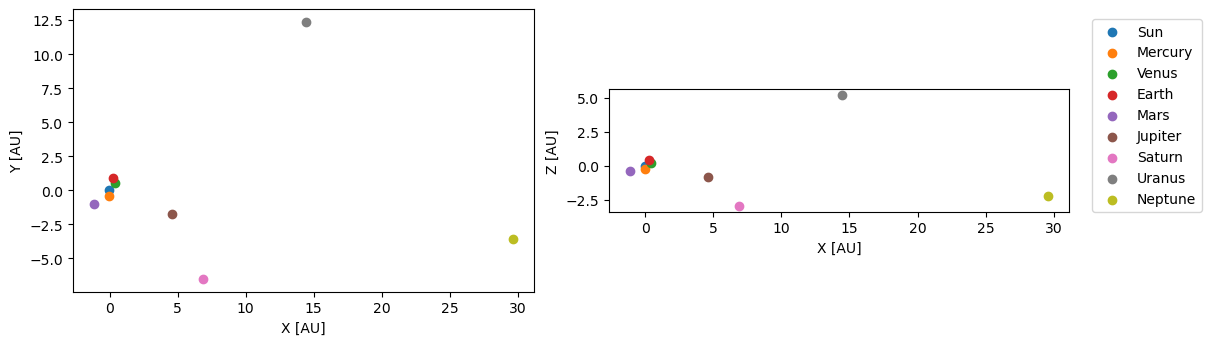

In [1]:
# we need to import the time module from astropy
from astropy.time import Time
# import some coordinate things from astropy
from astropy.coordinates import solar_system_ephemeris
from astropy.coordinates import get_body_barycentric_posvel
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt

# Question 1: Simulating the solar system

# pick a time (please use either this or the current time)
t = Time("2021-12-07 10:00")

## a)
# Initialize the planets and the Sun
with solar_system_ephemeris.set('jpl'):
    planets = ['sun', 'mercury', 'venus', 'earth', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune']
    positions = {}
    for planet in planets:
        posvel = get_body_barycentric_posvel(planet, t)
        positions[planet] = posvel[0]

# Extract x, y, z positions
x = np.array([positions[planet].x.to_value(u.AU) for planet in planets])
y = np.array([positions[planet].y.to_value(u.AU) for planet in planets])
z = np.array([positions[planet].z.to_value(u.AU) for planet in planets])

# Define planet names
names = np.array(['Sun', 'Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune'])

# Plotting (x, y) positions
fig, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
for i, obj in enumerate(names):
    ax[0].scatter(x[i], y[i], label=obj)
    ax[1].scatter(x[i], z[i], label=obj)

ax[0].set_aspect('equal', 'box')
ax[1].set_aspect('equal', 'box')
ax[0].set(xlabel='X [AU]', ylabel='Y [AU]')
ax[1].set(xlabel='X [AU]', ylabel='Z [AU]')

plt.legend(loc=(1.05, 0))
plt.savefig("fig1a.png")
plt.show() # da sostituire con plt.close()

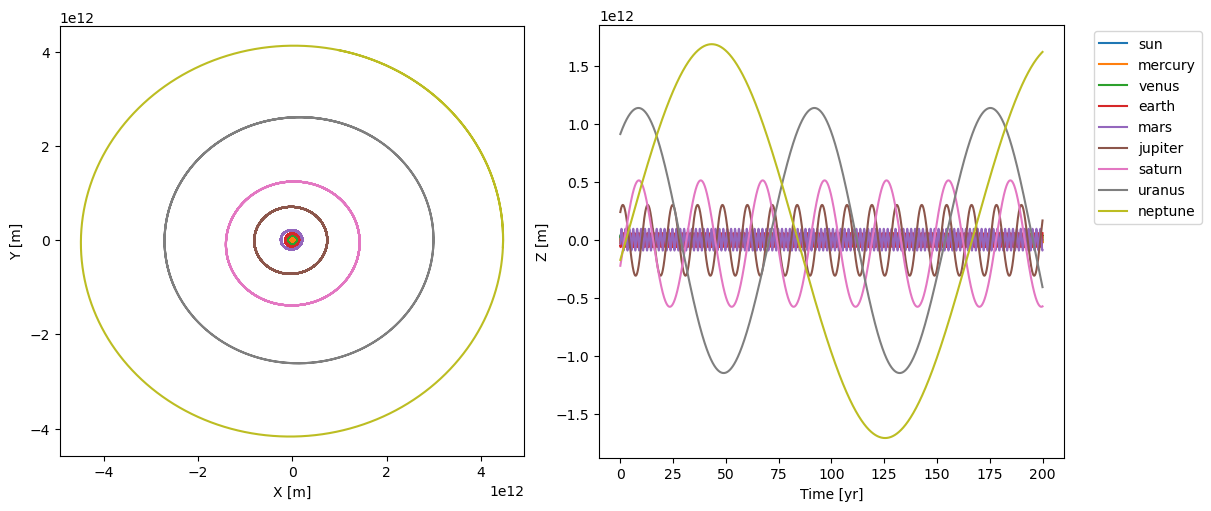

In [10]:
## b)
# Define necessary parameters and constants
G = 6.67430e-11  # gravitational constant in m^3 kg^-1 s^-2
m_sun = 1.989e30  # mass of the Sun in kg

# Mass of the planets (in kg)
m_planet = {
    'mercury': 3.3011e23,
    'venus': 4.8675e24,
    'earth': 5.97237e24,
    'mars': 6.4171e23,
    'jupiter': 1.8982e27,
    'saturn': 5.6834e26,
    'uranus': 8.6810e25,
    'neptune': 1.02413e26
}

# Define function to calculate gravitational force between Sun and other planets
def gravitational_force(mass1, mass2, distance):
    return G * mass1 * mass2 / distance**2

# Initialize positions and velocities of the planets at t = 0
positions = {'sun': np.array([0.0, 0.0, 0.0])}  # Initialize Sun at origin
velocities = {'sun': np.array([0.0, 0.0, 0.0])}  # Initialize Sun's velocity as zero

with solar_system_ephemeris.set('builtin'):
    for planet in planets[1:]:  # Skip Sun
        posvel = get_body_barycentric_posvel(planet, t)
        positions[planet] = np.array([posvel[0].x.to(u.m).value, posvel[0].y.to(u.m).value, posvel[0].z.to(u.m).value])
        velocities[planet] = np.array([posvel[1].x.to(u.m/u.s).value, posvel[1].y.to(u.m/u.s).value, posvel[1].z.to(u.m/u.s).value])

time_steps = 200 * 365 * 2  # 200 years with a time step of 0.5 days
dt = 0.5 * 24 * 3600  # time step in seconds
positions_history = {'sun': [], 'mercury': [], 'venus': [], 'earth': [], 'mars': [], 'jupiter': [], 'saturn': [], 'uranus': [], 'neptune': []}

for step in range(time_steps):
    # Update velocities (v_i+1/2)
    for planet in planets[1:]:
        r = positions[planet] - positions['sun']
        r_mag = np.linalg.norm(r)
        acceleration = - gravitational_force(m_sun, m_planet[planet], r_mag) * r / r_mag / m_planet[planet]
        velocities[planet] += acceleration * dt / 2
    
    # Update positions (x_i+1)
    for planet in planets[1:]:
        positions[planet] += velocities[planet] * dt
    
    # Store positions for plotting
    for planet in planets:
        positions_history[planet].append(positions[planet].copy())
    
    # Update velocities again (v_i+1)
    for planet in planets[1:]:
        r = positions[planet] - positions['sun']
        r_mag = np.linalg.norm(r)
        acceleration = - gravitational_force(m_sun, m_planet[planet], r_mag) * r / r_mag / m_planet[planet]
        velocities[planet] += acceleration * dt / 2

for planet in planets:
    positions_history[planet] = np.array(positions_history[planet])

# Extract x, y, z coordinates for all planets
x_leapfrog = [positions_history[planet][:, 0]/AU for planet in planets]  
y_leapfrog = [positions_history[planet][:, 1]/AU for planet in planets]  
z_leapfrog = [positions_history[planet][:, 2]/AU for planet in planets]  

# Convert time to years
time = np.linspace(0, 200, time_steps)

# Create main plot with two subplots for all planets
fig, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Plot x-y plane for all planets
for i, planet in enumerate(planets):
    ax[0].plot(x_leapfrog[i], y_leapfrog[i], label=planet)

# Plot time versus z plane for all planets
for i, planet in enumerate(planets):
    ax[1].plot(time, z_leapfrog[i], label=planet)

# Set labels and title
ax[0].set_aspect('equal', 'box')
ax[0].set(xlabel='X [m]', ylabel='Y [m]')
ax[1].set(xlabel='Time [yr]', ylabel='Z [m]')

# Show legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Save figure
plt.savefig("fig1b.png")

# Show figure
plt.show()

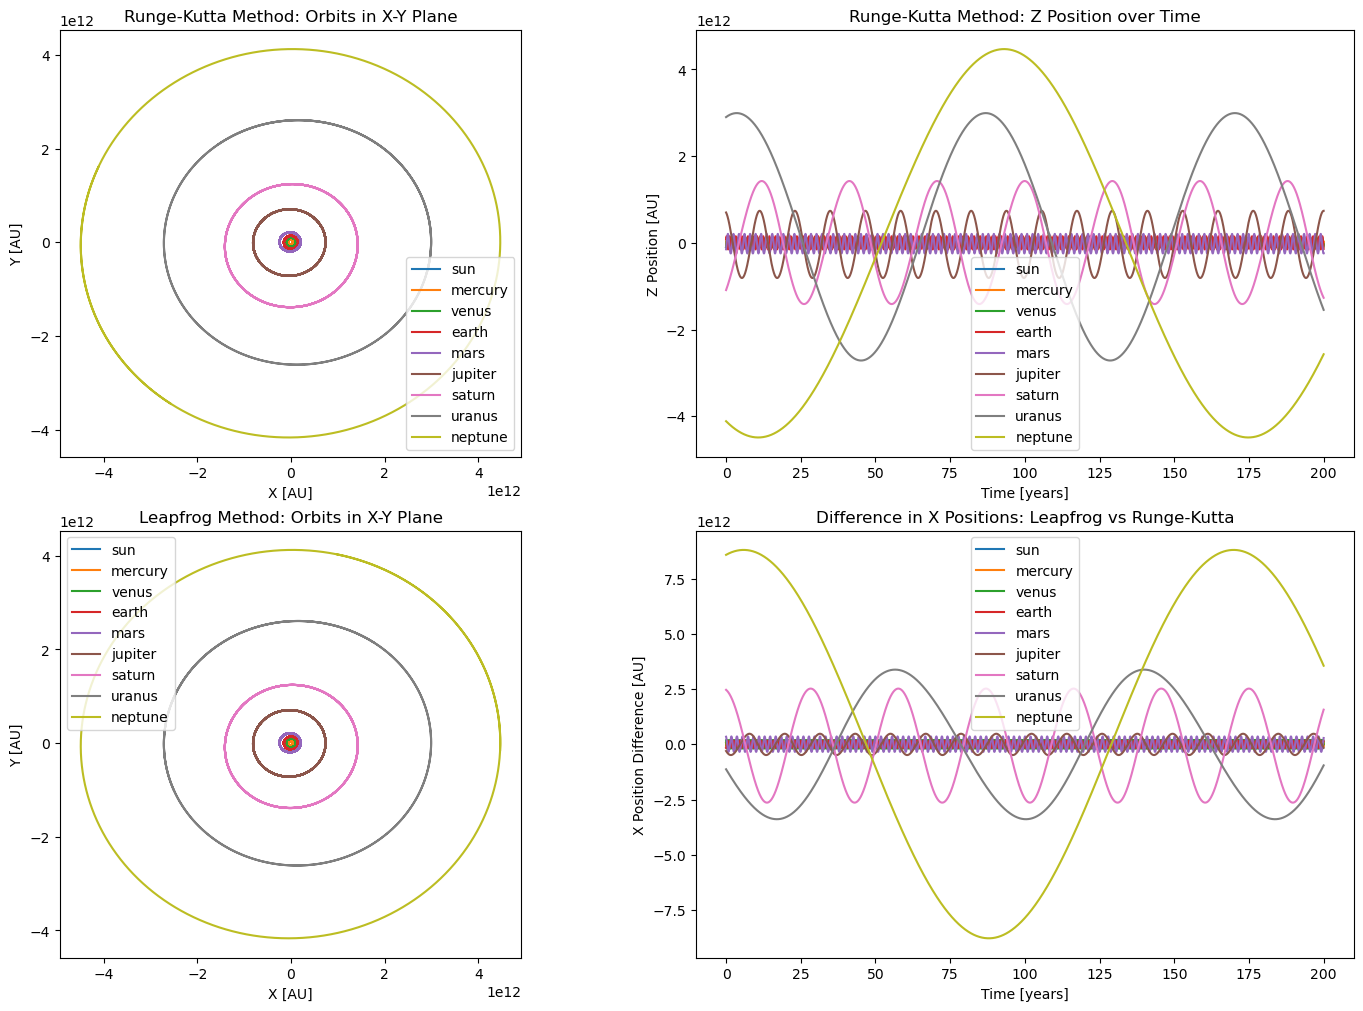

In [12]:
# Runge-Kutta 4th order method
positions = {planet: positions[planet] for planet in planets}
velocities = {planet: velocities[planet] for planet in planets}
positions_history_rk4 = {planet: [] for planet in planets}

def rk4_step(pos, vel, dt, mass):
    def acceleration(pos, mass):
        r = pos - positions['sun']
        r_mag = np.linalg.norm(r)
        return -gravitational_force(m_sun, mass, r_mag) * r / r_mag / mass
    
    k1v = {planet: acceleration(pos[planet], m_planet[planet]) * dt for planet in planets if planet != 'sun'}
    k1x = {planet: vel[planet] * dt for planet in planets if planet != 'sun'}

    k2v = {planet: acceleration(pos[planet] + 0.5 * k1x[planet], m_planet[planet]) * dt for planet in planets if planet != 'sun'}
    k2x = {planet: (vel[planet] + 0.5 * k1v[planet]) * dt for planet in planets if planet != 'sun'}

    k3v = {planet: acceleration(pos[planet] + 0.5 * k2x[planet], m_planet[planet]) * dt for planet in planets if planet != 'sun'}
    k3x = {planet: (vel[planet] + 0.5 * k2v[planet]) * dt for planet in planets if planet != 'sun'}

    k4v = {planet: acceleration(pos[planet] + k3x[planet], m_planet[planet]) * dt for planet in planets if planet != 'sun'}
    k4x = {planet: (vel[planet] + k3v[planet]) * dt for planet in planets if planet != 'sun'}

    for planet in planets:
        if planet == 'sun':
            continue
        vel[planet] += (k1v[planet] + 2 * k2v[planet] + 2 * k3v[planet] + k4v[planet]) / 6
        pos[planet] += (k1x[planet] + 2 * k2x[planet] + 2 * k3x[planet] + k4x[planet]) / 6

for step in range(time_steps):
    rk4_step(positions, velocities, dt, m_planet)
    
    # Store positions for plotting
    for planet in planets:
        positions_history_rk4[planet].append(positions[planet].copy())

# Convert positions_history_rk4 to arrays for easier manipulation
for planet in planets:
    positions_history_rk4[planet] = np.array(positions_history_rk4[planet])

# Extract x, y, z coordinates for all planets
x_rk4 = [positions_history_rk4[planet][:, 0] for planet in planets]
y_rk4 = [positions_history_rk4[planet][:, 1] for planet in planets]
z_rk4 = [positions_history_rk4[planet][:, 2] for planet in planets]

# Calculate differences in x positions
x_diff = [x_leapfrog[i] - x_rk4[i] for i in range(len(planets))]

# Convert time to years
time = np.linspace(0, 200, time_steps)

# Create subplots for Leapfrog and Runge-Kutta methods
fig, ax = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)

# Plot x-y plane for all planets using Runge-Kutta
for i, planet in enumerate(planets):
    ax[0, 0].plot(x_rk4[i], y_rk4[i], label=planet)
ax[0, 0].set_aspect('equal', 'box')
ax[0, 0].set(xlabel='X [AU]', ylabel='Y [AU]', title='Runge-Kutta Method: Orbits in X-Y Plane')
ax[0, 0].legend()

# Plot z positions over time for all planets using Runge-Kutta
for i, planet in enumerate(planets):
    ax[0, 1].plot(time, x_rk4[i], label=planet)
ax[0, 1].set(xlabel='Time [years]', ylabel='Z Position [AU]', title='Runge-Kutta Method: Z Position over Time')
ax[0, 1].legend()

# Plot x-y plane for all planets using Runge-Kutta
for i, planet in enumerate(planets):
    ax[1, 0].plot(x_leapfrog[i], y_leapfrog[i], label=planet)
ax[1, 0].set_aspect('equal', 'box')
ax[1, 0].set(xlabel='X [AU]', ylabel='Y [AU]', title='Leapfrog Method: Orbits in X-Y Plane')
ax[1, 0].legend()

# Plot differences in x positions over time
for i, planet in enumerate(planets):
    ax[1, 1].plot(time, x_diff[i], label=planet)
ax[1, 1].set(xlabel='Time [years]', ylabel='X Position Difference [AU]', title='Difference in X Positions: Leapfrog vs Runge-Kutta')
ax[1, 1].legend()

plt.show()

## Exercise 2

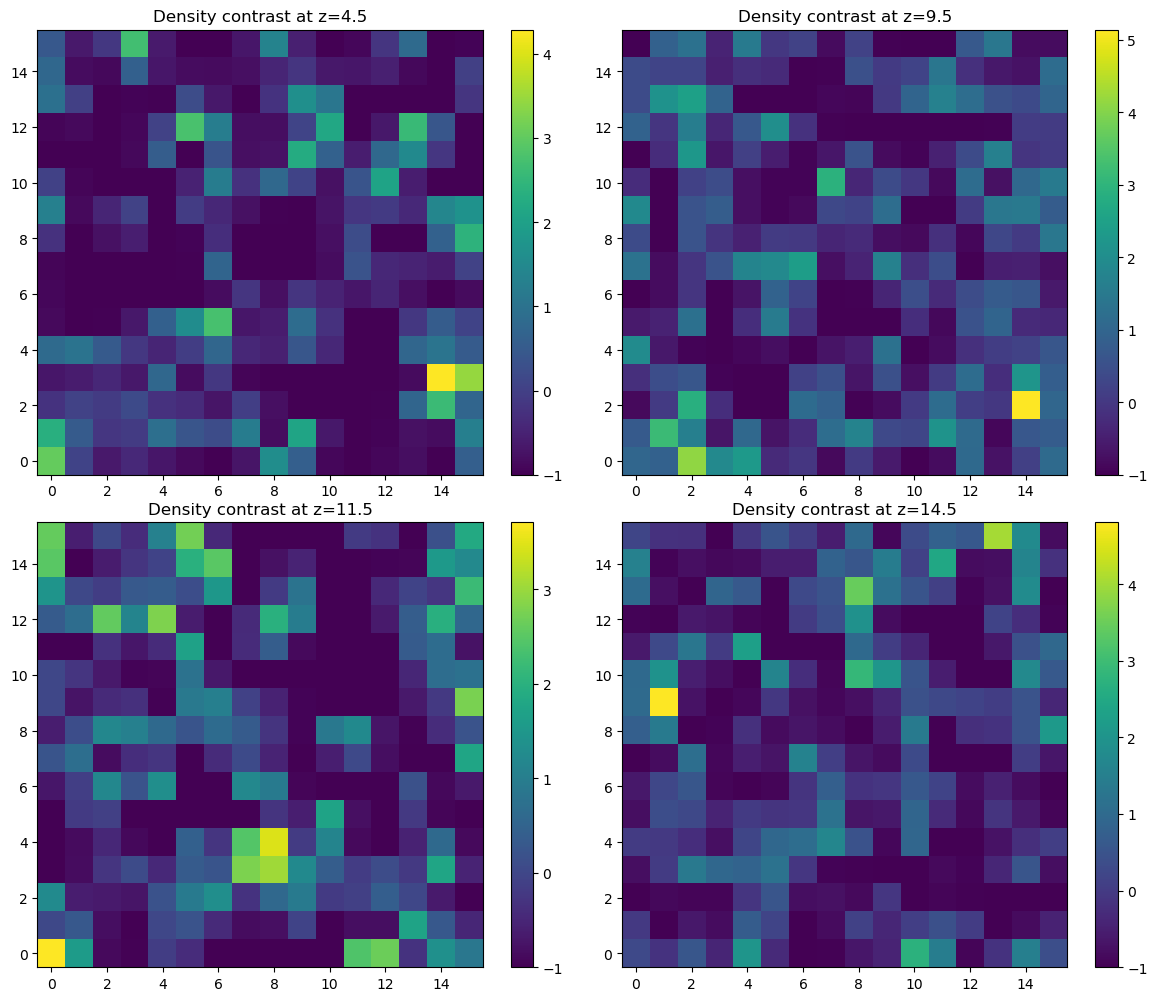

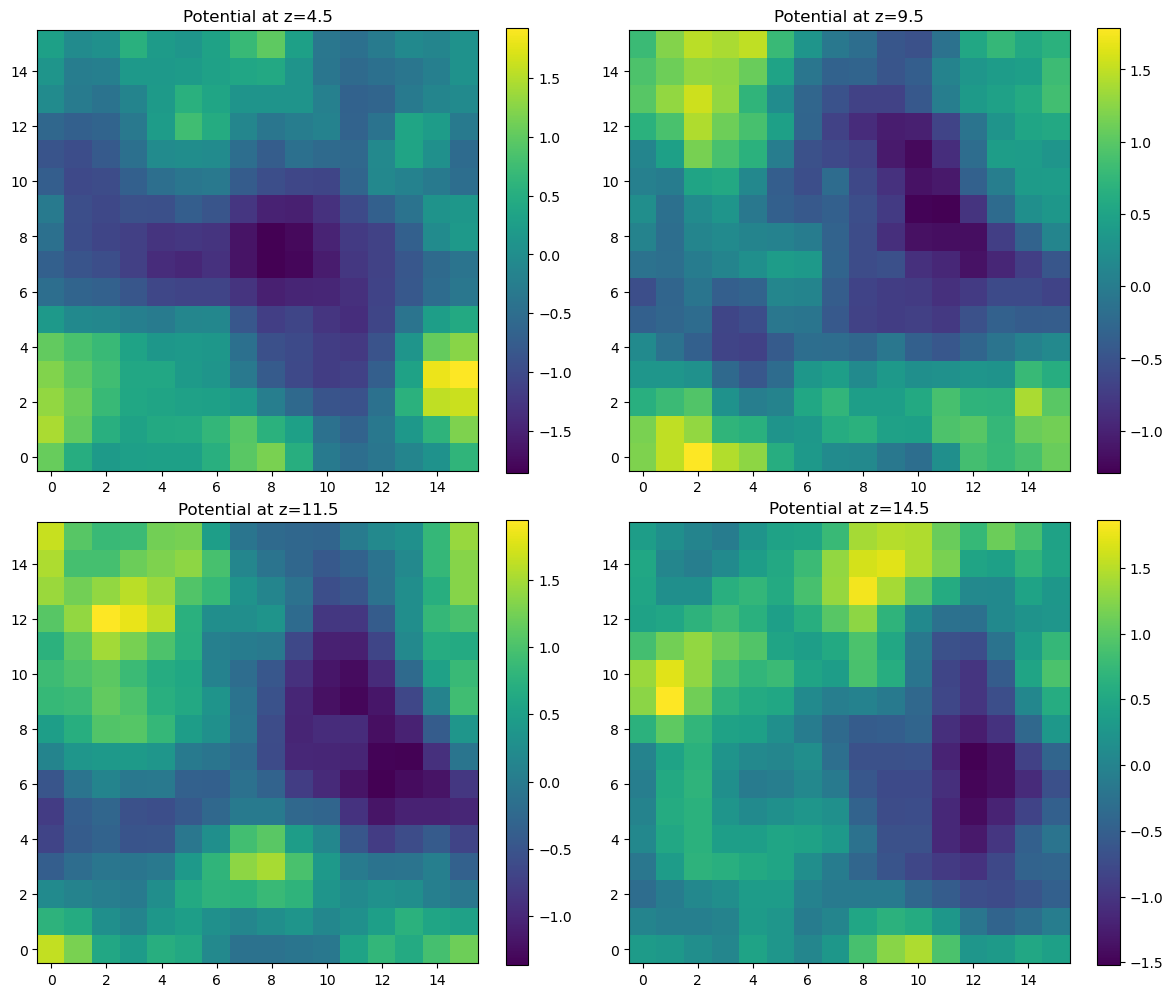

/var/folders/pz/5qchhm2j7nn9jlkwfg3_yckc0000gn/T/ipykernel_16769/3770809805.py:153: RuntimeWarning: divide by zero encountered in log10
  log_phi_k = np.log10(np.abs(phi_k))


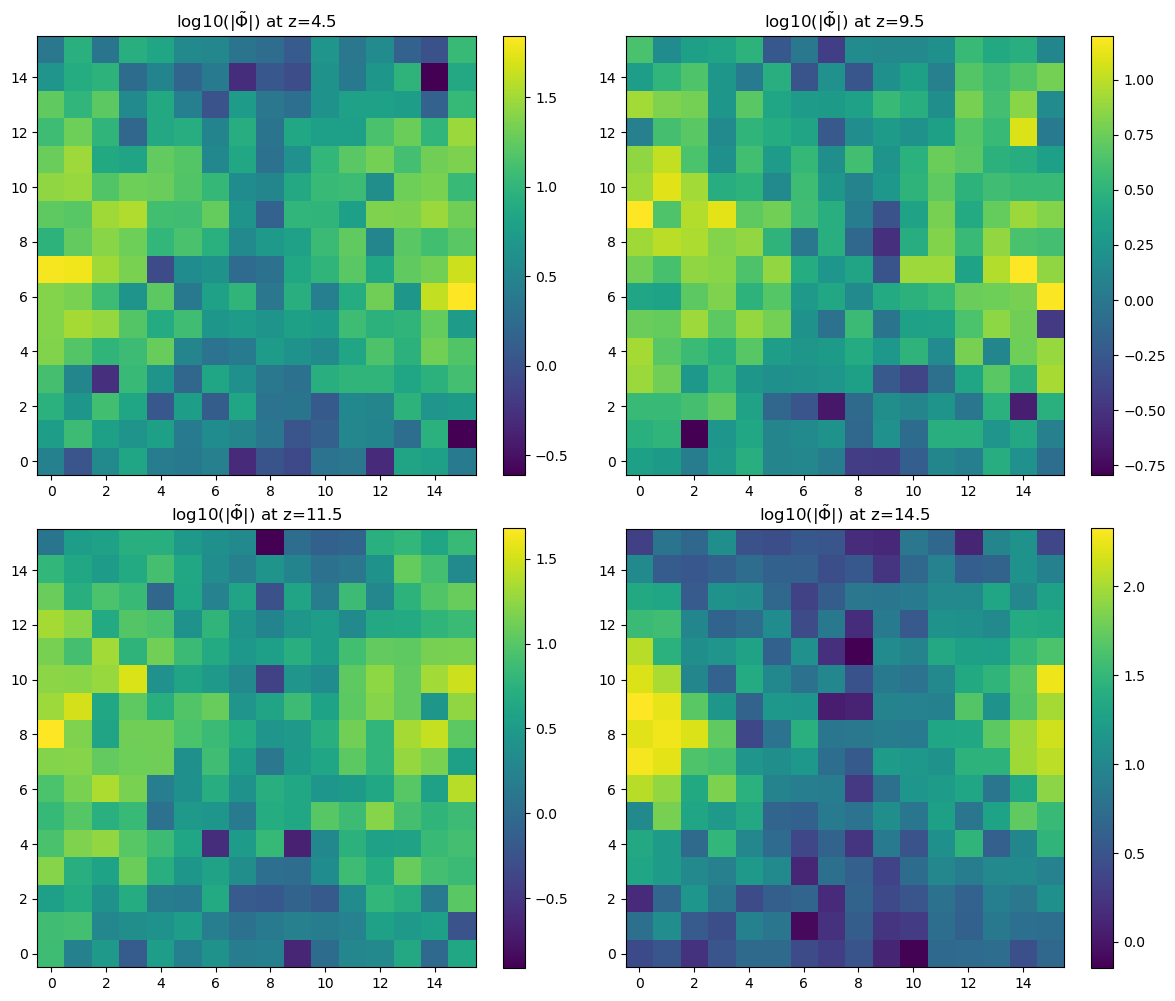

In [30]:
# FFT using Cooley-Tukey algorithm (recursively)
def fft_recursive(x):
    N = len(x)
    if N <= 1:
        return x
    even = fft_recursive(x[0::2])
    odd = fft_recursive(x[1::2])
    T = [np.exp(-2j * np.pi * k / N) * odd[k] for k in range(N // 2)]
    return [even[k] + T[k] for k in range(N // 2)] + [even[k] - T[k] for k in range(N // 2)]

# Inverse FFT using Cooley-Tukey algorithm  (recursively)
def ifft_recursive(x):
    N = len(x)
    if N <= 1:
        return x
    even = ifft_recursive(x[0::2])
    odd = ifft_recursive(x[1::2])
    T = [np.exp(2j * np.pi * k / N) * odd[k] for k in range(N // 2)]
    return [(even[k] + T[k]) / 2 for k in range(N // 2)] + [(even[k] - T[k]) / 2 for k in range(N // 2)]

def fft3d(data):
    n = data.shape[0]
    fft_data = np.zeros_like(data, dtype=complex)

    # Apply FFT to each dimension
    for i in range(n):
        for j in range(n):
            fft_data[i, j, :] = fft_recursive(data[i, j, :])
        for k in range(n):
            fft_data[i, :, k] = fft_recursive(fft_data[i, :, k])
    for j in range(n):
        for k in range(n):
            fft_data[:, j, k] = fft_recursive(fft_data[:, j, k])

    return fft_data

def ifft3d(data):
    n = data.shape[0]
    ifft_data = np.zeros_like(data, dtype=complex)

    # Apply inverse FFT to each dimension
    for i in range(n):
        for j in range(n):
            ifft_data[i, j, :] = ifft_recursive(data[i, j, :])
        for k in range(n):
            ifft_data[i, :, k] = ifft_recursive(ifft_data[i, :, k])
    for j in range(n):
        for k in range(n):
            ifft_data[:, j, k] = ifft_recursive(ifft_data[:, j, k])

    return ifft_data

def fftfreq(n):
    """Returns the Discrete Fourier Transform sample frequencies."""
    val = 1.0 / n
    results = np.zeros(n)
    N = (n - 1) // 2 + 1
    p1 = np.arange(0, N, dtype=int)
    results[:N] = p1
    p2 = np.arange(-(n//2), 0, dtype=int)
    results[N:] = p2
    return results * val

def fftshift(x):
    """Shift the zero-frequency component to the center of the spectrum."""
    n = len(x)
    p2 = x[n//2:]
    p1 = x[:n//2]
    return np.concatenate((p2, p1))

# Initialize the random seed and generate particle positions
np.random.seed(121)

n_mesh = 16
n_part = 1024
positions = np.random.uniform(low=0, high=n_mesh, size=(3, n_part))

# Grid and density initialization
grid = np.arange(n_mesh) + 0.5
densities = np.zeros(shape=(n_mesh, n_mesh, n_mesh))
cellvol = 1.0

# Cloud-In-Cell method for density assignment
for p in range(n_part):
    cellind = np.zeros(shape=(3, 2), dtype=int)
    dist = np.zeros(shape=(3, 2))

    for i in range(3):
        cellind[i] = np.where((abs(positions[i, p] - grid) < 1) |
                              (abs(positions[i, p] - grid - 16) < 1) | 
                              (abs(positions[i, p] - grid + 16) < 1))[0]
        dist[i] = abs(positions[i, p] - grid[cellind[i].astype(int)])

    for (x, dx) in zip(cellind[0], dist[0]):    
        for (y, dy) in zip(cellind[1], dist[1]):
            for (z, dz) in zip(cellind[2], dist[2]):
                if dx > 15: dx = abs(dx - 16)
                if dy > 15: dy = abs(dy - 16)
                if dz > 15: dz = abs(dz - 16)

                densities[x, y, z] += (1 - dx)*(1 - dy)*(1 - dz) / cellvol

# Convert densities to density contrast delta
mean_density = n_part / n_mesh**3
delta = (densities - mean_density) / mean_density

# Plot the 2D slices of delta
slices = [4.5, 9.5, 11.5, 14.5]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, z in enumerate(slices):
    zi = int(z)
    im = axes[i].imshow(delta[:, :, zi], origin='lower', cmap='viridis')
    axes[i].set_title(f'Density contrast at z={z}')
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.savefig("fig2a.png")
plt.show()

# Perform FFT on delta
delta_k = fft3d(delta)

# Calculate potential in Fourier space
k = fftfreq(n_mesh) * 2 * np.pi
kx, ky, kz = np.meshgrid(k, k, k, indexing='ij')
k_squared = kx**2 + ky**2 + kz**2
k_squared[0, 0, 0] = 1  # avoid division by zero

phi_k = delta_k / k_squared
phi_k[0, 0, 0] = 0  # enforce zero mean for potential

# Perform inverse FFT to get phi in real space
#phi = np.real(ifft3d(phi_k))
phi = ifft3d(phi_k).real

# Plot the 2D slices of phi
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, z in enumerate(slices):
    zi = int(z)
    im = axes[i].imshow(phi[:, :, zi], origin='lower', cmap='viridis')
    axes[i].set_title(f'Potential at z={z}')
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.savefig("fig2b.png")
plt.show()

# Plot the log of the absolute value of the Fourier-transformed potential
log_phi_k = np.log10(np.abs(phi_k))
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, z in enumerate(slices):
    zi = int(z)
    im = axes[i].imshow(fftshift(log_phi_k[:, :, zi]), origin='lower', cmap='viridis')
    axes[i].set_title(f'log10(|$\~\Phi$|) at z={z}')
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.savefig("fig2c.png")
plt.show()

# TODO : compute np.real manually. optional: follow the provided plotting routine. c

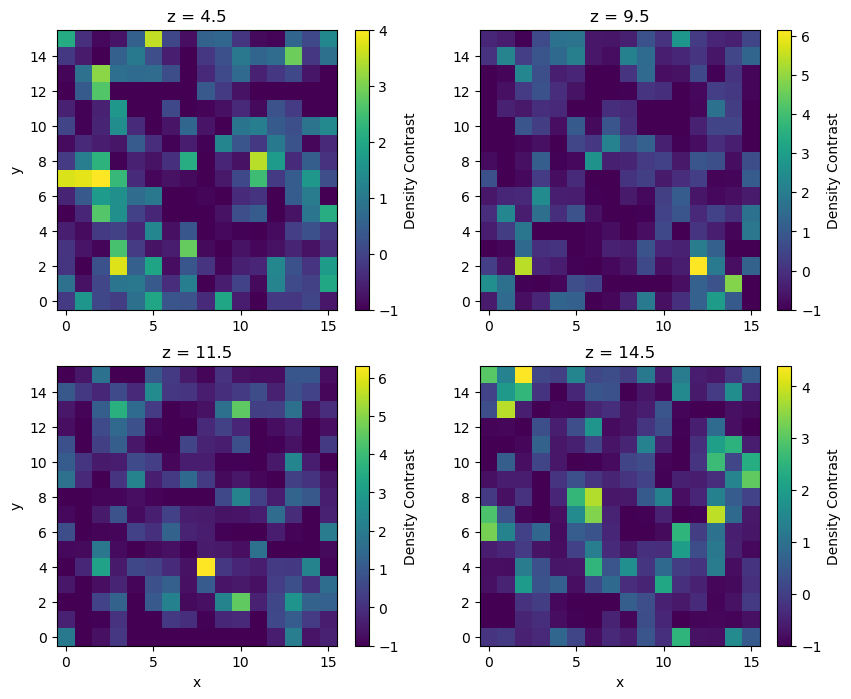

In [9]:
# Question 2: Calculating forces with the FFT

np.random.seed(121) # DO NOT CHANGE (so positions are the same for all students)

n_mesh = 16
n_part = 1024
positions = np.random.uniform(low=0, high=n_mesh, size=(3, n_part))

grid = np.arange(n_mesh) + 0.5
densities = np.zeros(shape=(n_mesh, n_mesh, n_mesh))
cellvol = 1.

for p in range(n_part):
    cellind = np.zeros(shape=(3, 2))
    dist = np.zeros(shape=(3, 2))

    for i in range(3):
        cellind[i] = np.where((abs(positions[i, p] - grid) < 1) |
                              (abs(positions[i, p] - grid - 16) < 1) | 
                              (abs(positions[i, p] - grid + 16) < 1))[0]
        dist[i] = abs(positions[i, p] - grid[cellind[i].astype(int)])

    cellind = cellind.astype(int)

    for (x, dx) in zip(cellind[0], dist[0]):    
        for (y, dy) in zip(cellind[1], dist[1]):
            for (z, dz) in zip(cellind[2], dist[2]):
                if dx > 15: dx = abs(dx - 16)
                if dy > 15: dy = abs(dy - 16)
                if dz > 15: dz = abs(dz - 16)

                densities[x, y, z] += (1 - dx)*(1 - dy)*(1 - dz) / cellvol

## a)
# Calculate the mean density
rho_mean = n_part / (n_mesh ** 3)

# Calculate the density contrast
density_contrast = (densities - rho_mean) / rho_mean

# Now you can use this density contrast in your plots
fig, ax = plt.subplots(2,2, figsize=(10,8))

# For z = 4.5, we take the slice at index 4
pcm = ax[0,0].pcolormesh(np.arange(0,16), np.arange(0,16), density_contrast[4])
ax[0,0].set(ylabel='y', title='z = 4.5')
fig.colorbar(pcm, ax=ax[0,0], label='Density Contrast')

# For z = 9.5, we take the slice at index 9
pcm = ax[0,1].pcolormesh(np.arange(0,16), np.arange(0,16), density_contrast[9])
ax[0,1].set(title='z = 9.5')
fig.colorbar(pcm, ax=ax[0,1], label='Density Contrast')

# For z = 11.5, we take the slice at index 11
pcm = ax[1,0].pcolormesh(np.arange(0,16), np.arange(0,16), density_contrast[11])
ax[1,0].set(ylabel='y', xlabel='x', title='z = 11.5')
fig.colorbar(pcm, ax=ax[1,0], label='Density Contrast')

# For z = 14.5, we take the slice at index 14
pcm = ax[1,1].pcolormesh(np.arange(0,16), np.arange(0,16), density_contrast[14])
ax[1,1].set(xlabel='x', title='z = 14.5')
fig.colorbar(pcm, ax=ax[1,1], label='Density Contrast')

ax[0,0].set_aspect('equal', 'box')
ax[0,1].set_aspect('equal', 'box')
ax[1,0].set_aspect('equal', 'box')
ax[1,1].set_aspect('equal', 'box')

plt.savefig("fig2a.png")
plt.show()



# Problem 2.a
densitycontrast = np.random.rand(16,16,16) # REPLACE
fig, ax = plt.subplots(2,2, figsize=(10,8))
pcm = ax[0,0].pcolormesh(np.arange(0,16), np.arange(0,16), densitycontrast[4])
ax[0,0].set(ylabel='y', title='z = 4.5')
fig.colorbar(pcm, ax=ax[0,0], label='Density')
pcm =ax[0,1].pcolormesh(np.arange(0,16), np.arange(0,16), densitycontrast[9])
ax[0,1].set(title='z = 9.5')
fig.colorbar(pcm, ax=ax[0,1], label='Density')
pcm = ax[1,0].pcolormesh(np.arange(0,16), np.arange(0,16), densitycontrast[11])
ax[1,0].set(ylabel='y', xlabel='x', title='z = 11.5')
fig.colorbar(pcm, ax=ax[1,0], label='Density')
pcm = ax[1,1].pcolormesh(np.arange(0,16), np.arange(0,16), densitycontrast[14])
ax[1,1].set(xlabel='x', title='z = 14.5')
fig.colorbar(pcm, ax=ax[1,1], label='Density')
ax[0,0].set_aspect('equal', 'box')
ax[0,1].set_aspect('equal', 'box')
ax[1,0].set_aspect('equal', 'box')
ax[1,1].set_aspect('equal', 'box')
plt.savefig("fig2a.png")
plt.close()

/var/folders/pz/5qchhm2j7nn9jlkwfg3_yckc0000gn/T/ipykernel_1069/432593243.py:36: RuntimeWarning: divide by zero encountered in divide
  potential_transformed = density_contrast_ft / k_squared
/var/folders/pz/5qchhm2j7nn9jlkwfg3_yckc0000gn/T/ipykernel_1069/432593243.py:36: RuntimeWarning: invalid value encountered in divide
  potential_transformed = density_contrast_ft / k_squared


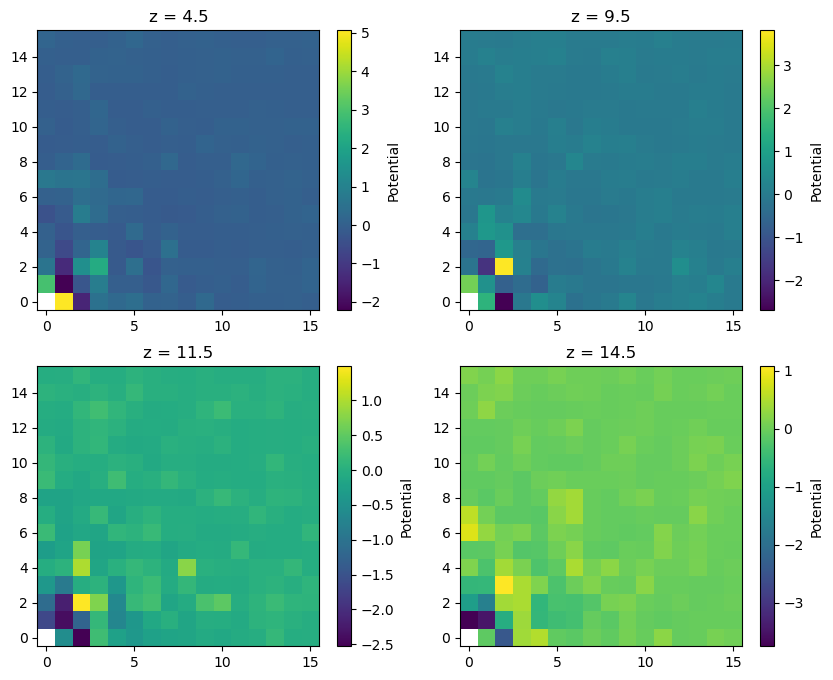

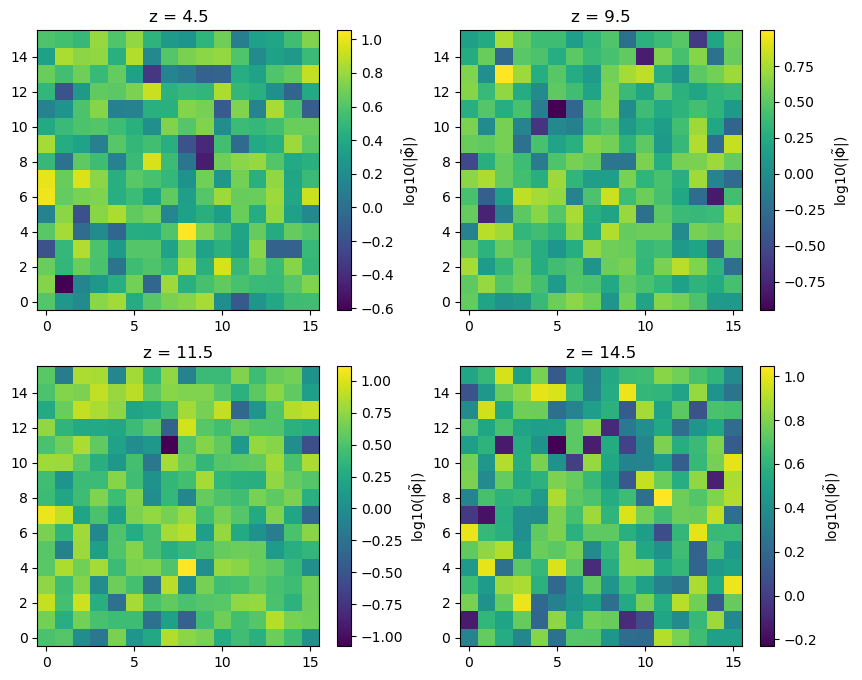

In [28]:
## b)
# Define the FFT using Cooley-Tukey algorithm
# Recursively (no-bit reversal needed)
def fft(x):
    N = len(x)
    if N <= 1:
        return x
    even = fft(x[0::2])
    odd =  fft(x[1::2])
    T= [np.exp(-2j*np.pi*k/N)*odd[k] for k in range(N//2)]
    return [even[k] + T[k] for k in range(N//2)] + [even[k] - T[k] for k in range(N//2)]

# Define the inverse FFT
def ifft(x):
    N = len(x)
    if N <= 1:
        return x
    even = ifft(x[0::2])
    odd = ifft(x[1::2])
    T = [np.exp(2j * np.pi * k / N) * odd[k] for k in range(N // 2)]
    return [(even[k] + T[k]) for k in range(N // 2)] + [(even[k] - T[k]) for k in range(N // 2)]


# Check if the FFT works
#x = np.random.random(16)
#print(np.allclose(fft(x), np.fft.fft(x)))
# Check if the IFFT works
#print(np.allclose(ifft(x), np.fft.ifft(x)))

# Compute the Fourier transform of the density contrast
density_contrast_ft = fft(density_contrast)

# Compute the transformed potential
k = np.arange(n_mesh)
k_squared = np.meshgrid(k, k, k)[0]**2 + np.meshgrid(k, k, k)[1]**2 + np.meshgrid(k, k, k)[2]**2
potential_transformed = density_contrast_ft / k_squared 

# Get the real potential from the transformed potential
potential = ifft(potential_transformed)

# Replace 'potential' and 'fourier_potential' with your calculated values
potential = np.real(ifft(potential_transformed)) # Take the real part (check if it can be used)
fourier_potential = np.abs(density_contrast_ft) 

# Plotting the potential
fig, ax = plt.subplots(2,2, figsize=(10,8))
for i, z in enumerate([4, 9, 11, 14]):
    pcm = ax[i//2, i%2].pcolormesh(np.arange(0,16), np.arange(0,16), potential[z])
    ax[i//2, i%2].set(title=f'z = {z + 0.5}')
    fig.colorbar(pcm, ax=ax[i//2, i%2], label='Potential')
plt.savefig("fig2b_pot.png")
plt.show()

# Plotting the Fourier-transformed potential
fig, ax = plt.subplots(2,2, figsize=(10,8))
for i, z in enumerate([4, 9, 11, 14]):
    pcm = ax[i//2, i%2].pcolormesh(np.arange(0,16), np.arange(0,16), np.log10(fourier_potential[z]))
    ax[i//2, i%2].set(title=f'z = {z + 0.5}')
    fig.colorbar(pcm, ax=ax[i//2, i%2], label=r'log10(|$\~\Phi$|)')
plt.savefig("fig2b_fourier.png")
plt.show() 

## Exercise 3
Logistic regression to classify galaxies into spirals and ellipticals
Cols in the file:
- 1: κ_co, a parameter indicating how much a galaxy is dominated by ordered rotation
- 2: estimate of their color, where higher values correspond to redder colours (i.e., older stellar populations)
- 3: measure of how extended each galaxy is
- 4:  the flux of an emission line used to measure the star formation rate of galaxies
- 5: morphology flag: 1 for spirals and 0 for ellipticals

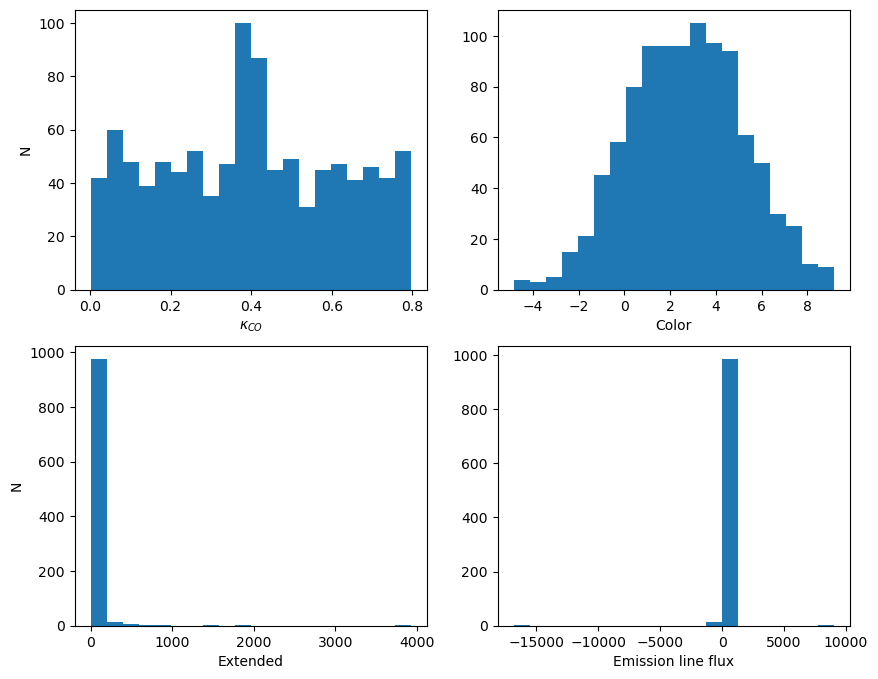

[-1.5818621330061005, -0.006612307828918272, -0.03475533387671271, 0.004149921715612883]
[1.5745590675879129, -0.7944354060046805, 0.2031450234565141, 0.016054878698581788]
[1.5319904751658617, 0.8573405014974259, -0.2079754178048099, 0.041663157702168045]
[1.2972154711566213, 1.226267345173266, 0.18588650058155307, 0.0006825469423304416]
[0.5181259591131053, 0.8257714425578112, -0.20025898584180632, 0.015557661890746857]
[-1.6475240134328304, -0.29096405782323304, -0.08488083597139741, 0.0018550137752091167]
[-1.3124959603603605, -0.9756536637063873, 0.06454576379671399, 0.006772650820885568]
[0.09418303994505568, -0.9715157240517418, -0.1525183484703763, 0.007745013475795202]
[-0.7308293662245412, -1.5201486235479371, -0.16544031497984416, 0.01175440493844444]
[-1.198035514238127, -0.774899524272911, -0.15538886731565343, 0.00959689257219208]


In [43]:
import numpy as np

# Read the data from the file
with open('galaxy_data.txt', 'r') as file:
    data = file.readlines()

# Process the data
features = []
labels = []
for line in data:
    # Split the line and convert to float
    values = [float(val) for val in line.split()]
    # Take the first 4 columns as features
    features.append(values[:4])
    # Take the 5th column as label
    labels.append(values[4])

# Convert lists to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Concatenate the features into a matrix of dimensions m x n
# In this case, the features are already in the required format (m x n) where m is the number of data points and n is the number of features (4 in this case)

# Calculate the mean and standard deviation of the features 
mean = [sum(feature) / len(feature) for feature in zip(*features)]
std_dev = [((sum((xi - mean[i]) ** 2 for xi in feature)) / len(feature)) ** 0.5 for i, feature in enumerate(zip(*features))]

# Apply feature scaling (standardization)
scaled_features = [[(xi - mean[i]) / std_dev[i] for i, xi in enumerate(x)] for x in features]

# Now, the scaled_features array has features with mean 0 and standard deviation 1


#bin_class = np.loadtxt('galaxy_data.txt', usecols=4, dtype=int)  # Load morphology flag
bin_class = np.loadtxt('galaxy_data.txt', usecols=4).astype(np.int64)

# Plot the distributions of the rescaled features
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].hist(features[:, 0], bins=20)
ax[0, 0].set(ylabel='N', xlabel=r'$\kappa_{CO}$')
ax[0, 1].hist(features[:, 1], bins=20)
ax[0, 1].set(xlabel='Color')
ax[1, 0].hist(features[:, 2], bins=20)
ax[1, 0].set(ylabel='N', xlabel='Extended')
ax[1, 1].hist(features[:, 3], bins=20)
ax[1, 1].set(xlabel='Emission line flux')
plt.savefig("fig3a.png")
plt.show()

# Print the features for the first 10 objects
for i in range(10):
    print(scaled_features[i])

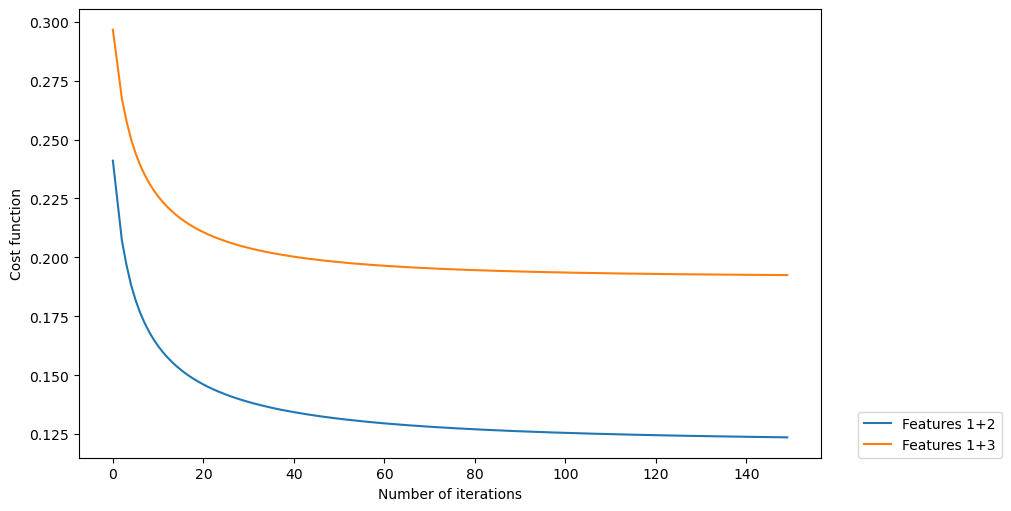

In [52]:
def bracketing(f, a, b, n):
    '''
    Inputs:
    f: Objective function
    args: Arguments of the objective function
    a, b: Starting and ending point of the bracket
    n: Number of iterations
    '''
    golden_ratio = (np.sqrt(5) + 1) / 2
    w = 1 / (1 + golden_ratio)

    # Ensure that f(b) < f(a)
    # If necessary, swap 'a' and 'b'
    if f(b) > f(a):
        a, b = b, a

    for _ in range(n):
        # Propose a point c using the golden ratio
        c = b + (b - a) * w

        # If f(c) > f(b), we have found a bracket
        if f(c) > f(b):
            return a, b, c
        # Otherwise, use a, b and c to find a new point by fitting a parabola
        else:
            # Compute the function values at a, b, and c
            fa = f(a)
            fb = f(b)
            fc = f(c)

            # The new point is given by the minimum of the parabola
            d = b - 0.5 * ((b - a) ** 2 * (fb - fc) - (b - c) ** 2 * (fb - fa)) / ((b - a) * (fb - fc) - (b - c) * (fb - fa))
     
            if b < d < c:
                # We might be done, so check if f(d) < f(c)
                if f(d) < f(c):
                    # New bracket = [b, d, c]
                    a = b
                    b = d
                # Otherwise, check if f(d) > f(b)
                elif f(d) > f(b):
                    # New bracket = [a, b, d]
                    c = d
                # If neither condition is met, the parabola is a bad fit
                # Set d using the golden ratio
                else:
                    d = c + (c - b) * w
            # If d is not in the interval [b, c], check if it is too far away
            # If it is, take another step
            elif abs(d - b) > 100 * abs(c - b):
                d = c + (c - b) * w

            # If not done, move all points over
            a = b
            b = c
            c = d

    # Final bracket
    return a, b, c


def golden_search(f, a, b, tol=1e-7):
    
    golden_ratio = (1+np.sqrt(5)) / 2
    w = 1/ (1+golden_ratio)
    
    # Set the intial bracket
    a, b, c = bracketing(f, a, b, n=3)
    
    while np.abs(c-a) > tol:
        # Set a boolean indicating whether [a,b] is the larger bracket compared to [b,c]
        # This is done for efficiency, since at each iteration the larger interval will be the one we didn't tighten in the previous step
        ab_larger = np.abs(b-a) > np.abs(c-b)
        
        if ab_larger:
            # x is the other edge of the larger interval
            x = a
        else:
            # If the condition is not true, we have [b,c] as the larger bracket
            x = c

        # Choose a new point inside the largest bracket 
        d = b + (x-b)* w

        if f(d) < f(b):
            # Tighten the bracket towards d
            # Depending on the largest bracket, update the values of a, b, and c by swapping
            if ab_larger:
                c, b = b, d
            else:
                a, b = b, d
        
        # If d is not a better point than b, adjust the brackets
        elif ab_larger:
            a=d
        else:
            c=d

        # If c-a is less than the tolerance
        if np.abs(c-a) <= tol:
            # If the function value at d is less than at b, return d
            if f(d) < f(b):
                return d, f(d)
            # Otherwise, return b
            else:
                return b, f(b)
            
    # If the loop ends without returning, return b (= central value of the bracket) and the function value at b
    return b, f(b)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cost_function(theta, X, y):
    m = len(y)
    h_theta = sigmoid(np.dot(X, theta))
    #print("Shape of predictions:", predictions.shape)
    error = (y * np.log(h_theta)) + ((1-y)*np.log(1-h_theta))
    cost = -1/m * np.sum(error)
    return cost

def gradient(theta, X, y):
    m = len(y)
    h_theta = sigmoid(np.dot(X, theta))
    grad = np.dot(X.T, (h_theta - y)) / m
    return grad

def logistic_regression_cg(X, y, theta, num_iters=150, tol=1e-7):
    cost_history = []
    d = -gradient(theta, X, y)

    for _ in range(num_iters):
        old_cost = cost_function(theta, X, y)
        alpha = golden_search(lambda a: cost_function(theta + a * d, X, y), 0, 1)[0]
        theta += alpha * d
        new_grad = gradient(theta, X, y)
        beta = np.dot(new_grad.T, new_grad) / np.dot(d.T, d)
        d = -new_grad + beta * d
        new_cost = cost_function(theta, X, y)
        cost_history.append(new_cost)
        if abs(new_cost - old_cost) < tol:
            break
    return theta, cost_history


scaled_features = np.array(scaled_features)

# Features 1 and 2
X_12 = scaled_features[:, :2]
theta = np.zeros(X_12.shape[1])
theta, cost_history_12 = logistic_regression_cg(X_12, labels, theta)

# Features 1 and 3
X_13 = scaled_features[:, [0, 2]]
theta = np.zeros(X_13.shape[1])
theta, cost_history_13 = logistic_regression_cg(X_13, labels, theta)

# Plotting
fig, ax  = plt.subplots(1,1, figsize=(10,5), constrained_layout=True)
ax.plot(np.arange(0, len(cost_history_12)), cost_history_12, label='Features 1+2')
ax.plot(np.arange(0, len(cost_history_13)), cost_history_13, label='Features 1+3')

ax.set(xlabel='Number of iterations', ylabel='Cost function')
plt.legend(loc=(1.05,0))
plt.savefig("fig3b.png")
plt.show()

# instead of using cost_history try cost_function[:,0] as done in the routine

Features: (0, 1)
True Positives: 474
False Positives: 24
True Negatives: 476
False Negatives: 26
F1 Score: 0.9498997995991985
Features: (0, 2)
True Positives: 435
False Positives: 55
True Negatives: 445
False Negatives: 65
F1 Score: 0.8787878787878789
Features: (0, 3)
True Positives: 433
False Positives: 55
True Negatives: 445
False Negatives: 67
F1 Score: 0.8765182186234817
Features: (1, 2)
True Positives: 392
False Positives: 110
True Negatives: 390
False Negatives: 108
F1 Score: 0.7824351297405189
Features: (1, 3)
True Positives: 393
False Positives: 111
True Negatives: 389
False Negatives: 107
F1 Score: 0.7828685258964143
Features: (2, 3)
True Positives: 91
False Positives: 118
True Negatives: 382
False Negatives: 409
F1 Score: 0.2566995768688293


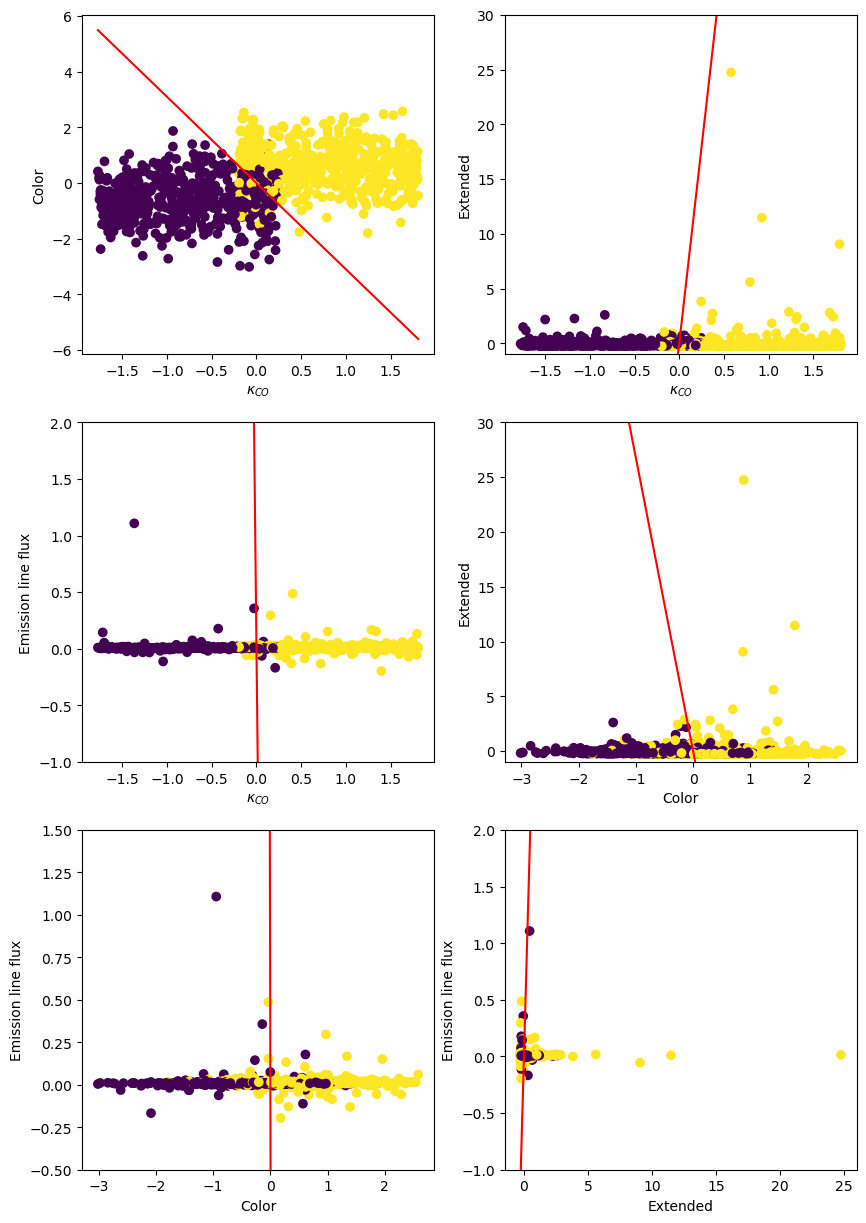

' # Problem 3.c\nfig, ax = plt.subplots(3,2,figsize=(10,15))\nnames = [r\'$\\kappa_{CO}$\', \'Color\', \'Extended\', \'Emission line flux\']\nplot_idx = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1]]\nfor i, comb in enumerate(itertools.combinations(np.arange(0,4), 2)):\n    ax[plot_idx[i][0],plot_idx[i][1]].scatter(features[:,comb[0]], features[:,comb[1]], c=bin_class)\n    ax[plot_idx[i][0],plot_idx[i][1]].set(xlabel=names[comb[0]], ylabel=names[comb[1]])\n    ax[plot_idx[i][0],plot_idx[i][1]].plot([0.5,0.5],[0,1], \'k--\')\nplt.savefig("fig3c.png")\nplt.close() '

In [53]:
import itertools

# Define a function to calculate the decision boundary
def decision_boundary(x, theta):
    return -theta[0]/theta[1] * x

fig, ax = plt.subplots(3,2,figsize=(10,15))
names = [r'$\kappa_{CO}$', 'Color', 'Extended', 'Emission line flux']
plot_idx = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1]]

# Iterate over all combinations of features
for i, comb in enumerate(itertools.combinations(np.arange(0,4), 2)):
    # Select the features
    X = scaled_features[:, comb]
    theta = np.zeros(X.shape[1])
    
    # Run logistic regression
    theta_min, _ = logistic_regression_cg(X, labels, theta)
    
    # Predict the labels
    y_pred = sigmoid(np.dot(X, theta)) >= 0.5
    
    # Compute the confusion matrix
    tp = np.sum((labels == 1) & (y_pred == 1))
    fp = np.sum((labels == 0) & (y_pred == 1))
    tn = np.sum((labels == 0) & (y_pred == 0))
    fn = np.sum((labels == 1) & (y_pred == 0))
    
    # Compute precision, recall, and F1 score
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    
    # Print the results
    print(f"Features: {comb}")
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"True Negatives: {tn}")
    print(f"False Negatives: {fn}")
    print(f"F1 Score: {f1}")
    
    # Plot the features and the decision boundary
    ax[plot_idx[i][0],plot_idx[i][1]].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    x_values = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
    ax[plot_idx[i][0],plot_idx[i][1]].plot(x_values, decision_boundary(x_values, theta_min), color='r')
    ax[plot_idx[i][0],plot_idx[i][1]].set(xlabel=names[comb[0]], ylabel=names[comb[1]])
    

    ax[0, 1].set_ylim(-1, 30)
    ax[1, 0].set_ylim(-1, 2)
    ax[1, 1].set_ylim(-1, 30)
    ax[2, 0].set_ylim(-0.5, 1.5)
    ax[2, 1].set_ylim(-1, 2)


plt.savefig("fig3c.png")
plt.show()


""" # Problem 3.c
fig, ax = plt.subplots(3,2,figsize=(10,15))
names = [r'$\kappa_{CO}$', 'Color', 'Extended', 'Emission line flux']
plot_idx = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1]]
for i, comb in enumerate(itertools.combinations(np.arange(0,4), 2)):
    ax[plot_idx[i][0],plot_idx[i][1]].scatter(features[:,comb[0]], features[:,comb[1]], c=bin_class)
    ax[plot_idx[i][0],plot_idx[i][1]].set(xlabel=names[comb[0]], ylabel=names[comb[1]])
    ax[plot_idx[i][0],plot_idx[i][1]].plot([0.5,0.5],[0,1], 'k--')
plt.savefig("fig3c.png")
plt.close() """

/var/folders/pz/5qchhm2j7nn9jlkwfg3_yckc0000gn/T/ipykernel_1069/3023210292.py:13: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  bin_class = np.loadtxt('galaxy_data.txt', usecols=4, dtype=int)


Features: (0, 1)
True Positives: 476
False Positives: 24
True Negatives: 474
False Negatives: 26
Precision: 0.9518072289156626
Recall: 0.948
F1 Score: 0.9498997995991985
Features: (0, 2)
True Positives: 439
False Positives: 61
True Negatives: 439
False Negatives: 61
Precision: 0.878
Recall: 0.878
F1 Score: 0.878
Features: (0, 3)
True Positives: 440
False Positives: 60
True Negatives: 438
False Negatives: 62
Precision: 0.8795180722891566
Recall: 0.876
F1 Score: 0.8777555110220441
Features: (1, 2)
True Positives: 390
False Positives: 110
True Negatives: 392
False Negatives: 108
Precision: 0.7808764940239044
Recall: 0.784
F1 Score: 0.7824351297405189
Features: (1, 3)
True Positives: 389
False Positives: 111
True Negatives: 393
False Negatives: 107
Precision: 0.7797619047619048
Recall: 0.786
F1 Score: 0.7828685258964143
Features: (2, 3)
True Positives: 370
False Positives: 130
True Negatives: 91
False Negatives: 409
Precision: 0.4117647058823529
Recall: 0.182
F1 Score: 0.2524271844660194


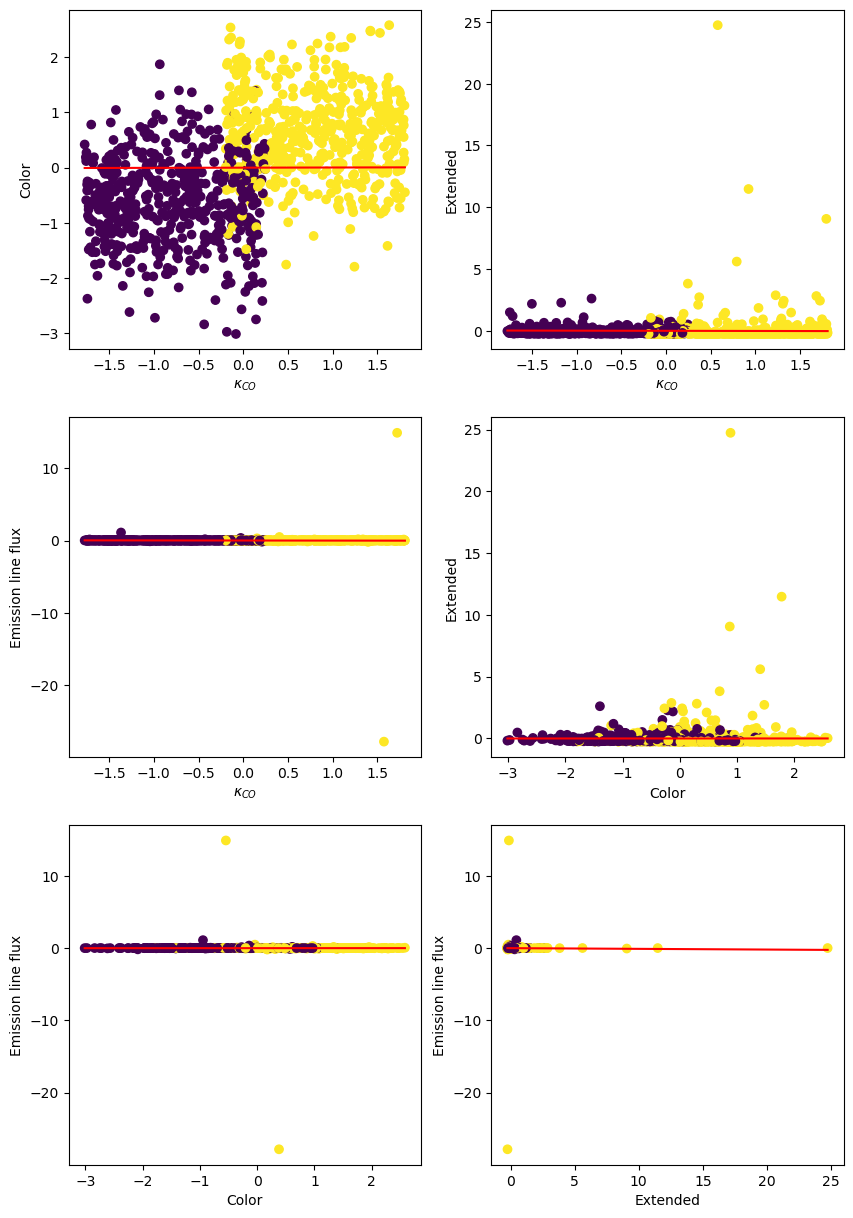

In [53]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Define decision boundary function
def decision_boundary(x, theta):
    return -theta[0] / theta[1] * x

# Load scaled features and labels
scaled_features = np.loadtxt('scaled_features.txt')
bin_class = np.loadtxt('galaxy_data.txt', usecols=4, dtype=int)
labels = (bin_class == 1).astype(int)

# Define feature names
names = [r'$\kappa_{CO}$', 'Color', 'Extended', 'Emission line flux']

# Plotting
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

# Iterate over all combinations of features
for i, comb in enumerate(itertools.combinations(np.arange(0, 4), 2)):
    # Select the features
    X = scaled_features[:, comb]

    # Initialize logistic regression model
    model = LogisticRegression()

    # Fit the model
    model.fit(X, labels)

    # Predict the labels
    y_pred = model.predict(X)

    # Compute the confusion matrix
    cm = confusion_matrix(labels, y_pred)
    tp, fp, fn, tn = cm.ravel()

    # Compute precision, recall, and F1 score
    precision = precision_score(labels, y_pred)
    recall = recall_score(labels, y_pred)
    f1 = f1_score(labels, y_pred)

    # Print the results
    print(f"Features: {comb}")
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"True Negatives: {tn}")
    print(f"False Negatives: {fn}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Plot the features and the decision boundary
    ax[i // 2, i % 2].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    x_values = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
    theta = np.append(model.intercept_, model.coef_)
    ax[i // 2, i % 2].plot(x_values, decision_boundary(x_values, theta), color='r')
    ax[i // 2, i % 2].set(xlabel=names[comb[0]], ylabel=names[comb[1]])

plt.savefig("fig3c_sklearn.png")
plt.show()

## Provided routines

In [ ]:
# PROVIDED CODE


# we need to import the time module from astropy
from astropy.time import Time
# import some coordinate things from astropy
from astropy.coordinates import solar_system_ephemeris
from astropy.coordinates import get_body_barycentric_posvel
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt

# Question 1: Simulating the solar system

# pick a time (please use either this or the current time)
t = Time("2021-12-07 10:00")

# initialize the planets; Mars is shown as an example
with solar_system_ephemeris.set('jpl'):
    mars = get_body_barycentric_posvel('mars', t)
    
print(mars)

marsposition = mars[0]
marsvelocity = mars[1]

# calculate the x position in AU
print(marsposition.x.to_value(u.AU))

# calculate the v_x velocity in AU/day
print(marsvelocity.x.to_value(u.AU/u.d))

# Problem 1.a
x, y, z = np.random.rand(3,9)*10-5 # REPLACE
names = np.array(['Sun', 'Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune'])
fig, ax = plt.subplots(1,2, figsize=(12,5), constrained_layout=True)
for i, obj in enumerate(names):
    ax[0].scatter(x[i], y[i], label=obj)
    ax[1].scatter(x[i], z[i], label=obj)
ax[0].set_aspect('equal', 'box')
ax[1].set_aspect('equal', 'box')
ax[0].set(xlabel='X [AU]', ylabel='Y [AU]')
ax[1].set(xlabel='X [AU]', ylabel='Z [AU]')
plt.legend(loc=(1.05,0))
plt.savefig("fig1a.png")
plt.close()

# Problem 1.b
# For visibility, you may want to do two versions of this plot: 
# one with all planets, and another zoomed in on the four inner planets
x, y, z = np.random.rand(3,9,10)*10-5 # REPLACE
time = x.copy()*0 +np.linspace(0,200,10) # REPLACE
fig, ax = plt.subplots(1,2, figsize=(12,5), constrained_layout=True)
for i, obj in enumerate(names):
    ax[0].plot(x[i,:], y[i,:], label=obj)
    ax[1].plot(time[i,:], z[i,:], label=obj)
ax[0].set_aspect('equal', 'box')
ax[0].set(xlabel='X [AU]', ylabel='Y [AU]')
ax[1].set(xlabel='Time [yr]', ylabel='Z [AU]')
plt.legend(loc=(1.05,0))
plt.savefig("fig1b.png")
plt.close()


# Bonus problem 1.c
x, y, z = np.random.rand(3,9,10)*10-5 # REPLACE
time = x.copy()*0 +np.linspace(0,200,10) # REPLACE
fig, ax = plt.subplots(1,2, figsize=(12,5), constrained_layout=True)
for i, obj in enumerate(np.flip(names)):
    ax[0].plot(time[i,:], z[i,:], label=obj)
    ax[1].plot(time[i,:], z[i,:], label=obj)
ax[0].set(xlabel='Time [yr]', ylabel='Z [AU]', title='Leapfrog')
ax[1].set(xlabel='Time [yr]', ylabel='Z [AU]', title='Other method')
plt.legend(loc=(1.05,0))
plt.savefig("fig1c.png")
plt.close()


import numpy as np
import matplotlib.pyplot as plt

# Question 2: Calculating forces with the FFT

np.random.seed(121) # DO NOT CHANGE (so positions are the same for all students)

n_mesh = 16
n_part = 1024
positions = np.random.uniform(low=0, high=n_mesh, size=(3, n_part))

grid = np.arange(n_mesh) + 0.5
densities = np.zeros(shape=(n_mesh, n_mesh, n_mesh))
cellvol = 1.

for p in range(n_part):
    cellind = np.zeros(shape=(3, 2))
    dist = np.zeros(shape=(3, 2))

    for i in range(3):
        cellind[i] = np.where((abs(positions[i, p] - grid) < 1) |
                              (abs(positions[i, p] - grid - 16) < 1) | 
                              (abs(positions[i, p] - grid + 16) < 1))[0]
        dist[i] = abs(positions[i, p] - grid[cellind[i].astype(int)])

    cellind = cellind.astype(int)

    for (x, dx) in zip(cellind[0], dist[0]):    
        for (y, dy) in zip(cellind[1], dist[1]):
            for (z, dz) in zip(cellind[2], dist[2]):
                if dx > 15: dx = abs(dx - 16)
                if dy > 15: dy = abs(dy - 16)
                if dz > 15: dz = abs(dz - 16)

                densities[x, y, z] += (1 - dx)*(1 - dy)*(1 - dz) / cellvol

# Problem 2.a
densitycontrast = np.random.rand(16,16,16) # REPLACE
fig, ax = plt.subplots(2,2, figsize=(10,8))
pcm = ax[0,0].pcolormesh(np.arange(0,16), np.arange(0,16), densitycontrast[4])
ax[0,0].set(ylabel='y', title='z = 4.5')
fig.colorbar(pcm, ax=ax[0,0], label='Density')
pcm =ax[0,1].pcolormesh(np.arange(0,16), np.arange(0,16), densitycontrast[9])
ax[0,1].set(title='z = 9.5')
fig.colorbar(pcm, ax=ax[0,1], label='Density')
pcm = ax[1,0].pcolormesh(np.arange(0,16), np.arange(0,16), densitycontrast[11])
ax[1,0].set(ylabel='y', xlabel='x', title='z = 11.5')
fig.colorbar(pcm, ax=ax[1,0], label='Density')
pcm = ax[1,1].pcolormesh(np.arange(0,16), np.arange(0,16), densitycontrast[14])
ax[1,1].set(xlabel='x', title='z = 14.5')
fig.colorbar(pcm, ax=ax[1,1], label='Density')
ax[0,0].set_aspect('equal', 'box')
ax[0,1].set_aspect('equal', 'box')
ax[1,0].set_aspect('equal', 'box')
ax[1,1].set_aspect('equal', 'box')
plt.savefig("fig2a.png")
plt.close()

# Problem 2.b
potential = np.random.rand(16,16,16) # REPLACE
fig, ax = plt.subplots(2,2, figsize=(10,8))
pcm = ax[0,0].pcolormesh(np.arange(0,16), np.arange(0,16), potential[4])
ax[0,0].set(ylabel='y', title='z = 4.5')
fig.colorbar(pcm, ax=ax[0,0], label='Potential')
pcm =ax[0,1].pcolormesh(np.arange(0,16), np.arange(0,16), potential[9])
ax[0,1].set(title='z = 9.5')
fig.colorbar(pcm, ax=ax[0,1], label='Potential')
pcm = ax[1,0].pcolormesh(np.arange(0,16), np.arange(0,16), potential[11])
ax[1,0].set(ylabel='y', xlabel='x', title='z = 11.5')
fig.colorbar(pcm, ax=ax[1,0], label='Potential')
pcm = ax[1,1].pcolormesh(np.arange(0,16), np.arange(0,16), potential[14])
ax[1,1].set(xlabel='x', title='z = 14.5')
fig.colorbar(pcm, ax=ax[1,1], label='Potential')
ax[0,0].set_aspect('equal', 'box')
ax[0,1].set_aspect('equal', 'box')
ax[1,0].set_aspect('equal', 'box')
ax[1,1].set_aspect('equal', 'box')
plt.savefig("fig2b_pot.png")
plt.close()

fourier_potential = np.random.rand(16,16,16) # REPLACE
fig, ax = plt.subplots(2,2, figsize=(10,8))
pcm = ax[0,0].pcolormesh(np.arange(0,16), np.arange(0,16), fourier_potential[4])
ax[0,0].set(ylabel='y', title='z = 4.5')
fig.colorbar(pcm, ax=ax[0,0], label=r'log10(|$\~\Phi$|)')
pcm =ax[0,1].pcolormesh(np.arange(0,16), np.arange(0,16), fourier_potential[9])
ax[0,1].set(title='z = 9.5')
fig.colorbar(pcm, ax=ax[0,1], label=r'log10(|$\~\Phi$|)')
pcm = ax[1,0].pcolormesh(np.arange(0,16), np.arange(0,16), fourier_potential[11])
ax[1,0].set(ylabel='y', xlabel='x', title='z = 11.5')
fig.colorbar(pcm, ax=ax[1,0], label=r'log10(|$\~\Phi$|)')
pcm = ax[1,1].pcolormesh(np.arange(0,16), np.arange(0,16), fourier_potential[14])
ax[1,1].set(xlabel='x', title='z = 14.5')
fig.colorbar(pcm, ax=ax[1,1], label=r'log10(|$\~\Phi$|)')
ax[0,0].set_aspect('equal', 'box')
ax[0,1].set_aspect('equal', 'box')
ax[1,0].set_aspect('equal', 'box')
ax[1,1].set_aspect('equal', 'box')
plt.savefig("fig2b_fourier.png")
plt.close()

## Exercise 3

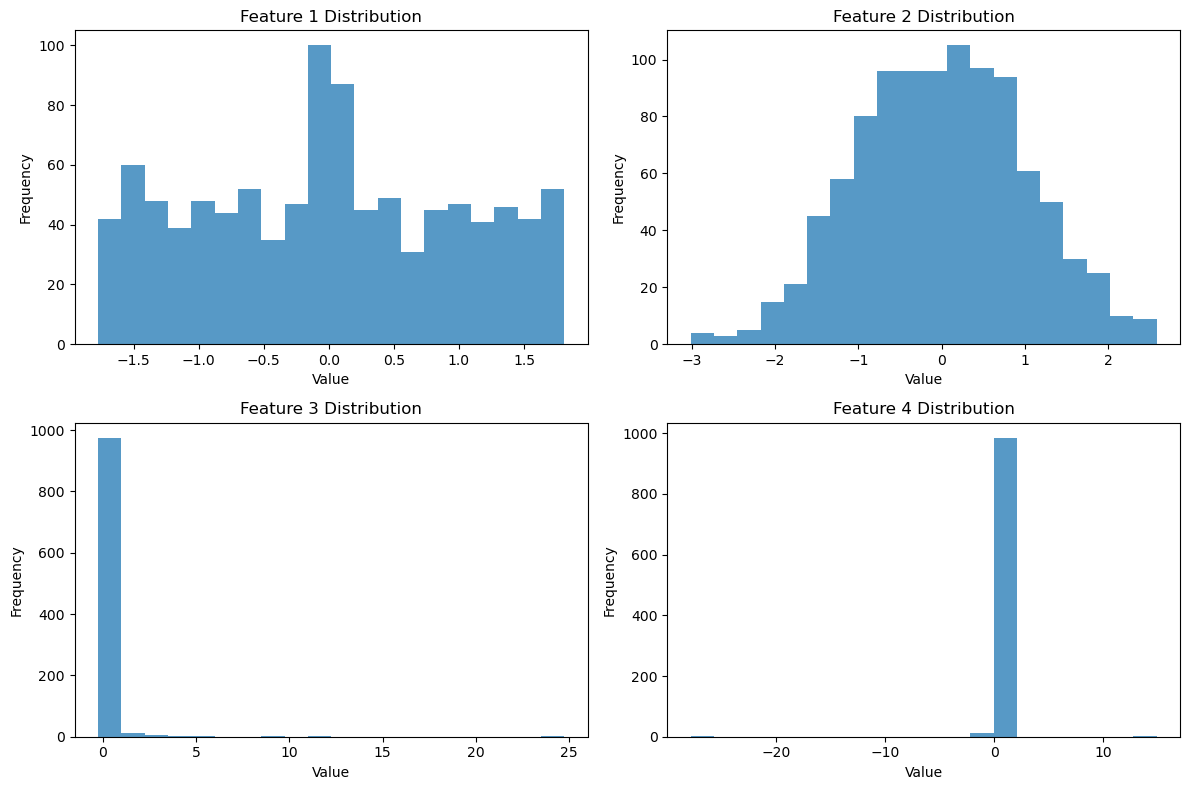

First 10 rescaled features:
[[-1.58186213e+00 -6.61230783e-03 -3.47553339e-02  4.14992172e-03]
 [ 1.57455907e+00 -7.94435406e-01  2.03145023e-01  1.60548787e-02]
 [ 1.53199048e+00  8.57340501e-01 -2.07975418e-01  4.16631577e-02]
 [ 1.29721547e+00  1.22626735e+00  1.85886501e-01  6.82546942e-04]
 [ 5.18125959e-01  8.25771443e-01 -2.00258986e-01  1.55576619e-02]
 [-1.64752401e+00 -2.90964058e-01 -8.48808360e-02  1.85501378e-03]
 [-1.31249596e+00 -9.75653664e-01  6.45457638e-02  6.77265082e-03]
 [ 9.41830399e-02 -9.71515724e-01 -1.52518348e-01  7.74501348e-03]
 [-7.30829366e-01 -1.52014862e+00 -1.65440315e-01  1.17544049e-02]
 [-1.19803551e+00 -7.74899524e-01 -1.55388867e-01  9.59689257e-03]]


In [24]:
# Read the data from the file
with open('galaxy_data.txt', 'r') as file:
    data = file.readlines()

# Process the data
features = []
labels = []
for line in data:
    values = [float(val) for val in line.split()]
    features.append(values[:4])
    labels.append(values[4])

# Convert lists to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Apply feature scaling (standardization)
features_mean = np.mean(features, axis=0) # usa quello precedente qui
features_std = np.std(features, axis=0)
features_scaled = (features - features_mean) / features_std

# Plot the distributions of the rescaled features
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for i in range(4):
    axes[i].hist(features_scaled[:, i], bins=20, alpha=0.75)
    axes[i].set_title(f'Feature {i+1} Distribution')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

# Save the rescaled features to a text file
np.savetxt('rescaled_features.txt', features_scaled, fmt='%.6f')

# Print the first 10 objects
print("First 10 rescaled features:")
print(features_scaled[:10])

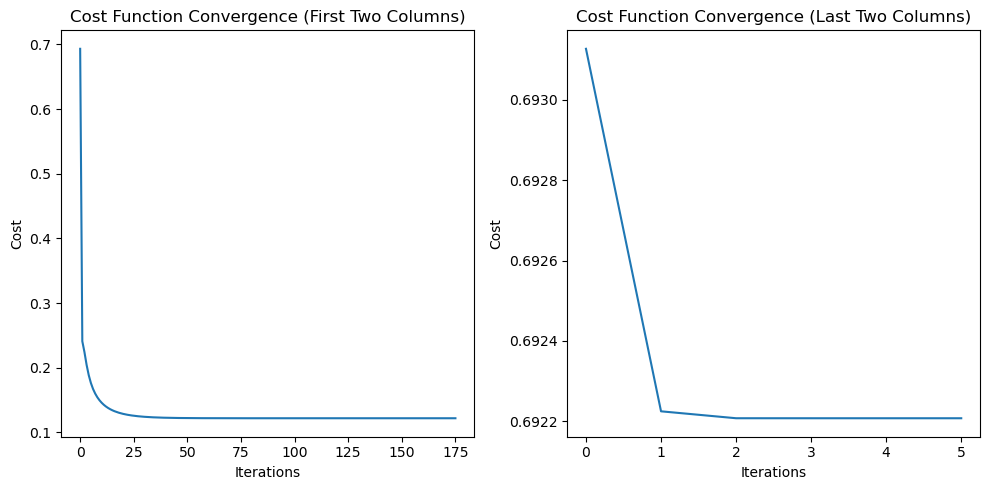

In [29]:
def bracketing(f, a, b, n):
    '''
    Inputs:
    f: Objective function
    args: Arguments of the objective function
    a, b: Starting and ending point of the bracket
    n: Number of iterations
    '''
    golden_ratio = (np.sqrt(5) + 1) / 2
    w = 1 / (1 + golden_ratio)

    # Ensure that f(b) < f(a)
    # If necessary, swap 'a' and 'b'
    if f(b) > f(a):
        a, b = b, a

    for _ in range(n):
        # Propose a point c using the golden ratio
        c = b + (b - a) * w

        # If f(c) > f(b), we have found a bracket
        if f(c) > f(b):
            return a, b, c
        # Otherwise, use a, b and c to find a new point by fitting a parabola
        else:
            # Compute the function values at a, b, and c
            fa = f(a)
            fb = f(b)
            fc = f(c)

            # The new point is given by the minimum of the parabola
            d = b - 0.5 * ((b - a) ** 2 * (fb - fc) - (b - c) ** 2 * (fb - fa)) / ((b - a) * (fb - fc) - (b - c) * (fb - fa))

            
            if b < d < c:
                # We might be done, so check if f(d) < f(c)
                if f(d) < f(c):
                    # New bracket = [b, d, c]
                    a = b
                    b = d
                # Otherwise, check if f(d) > f(b)
                elif f(d) > f(b):
                    # New bracket = [a, b, d]
                    c = d
                # If neither condition is met, the parabola is a bad fit
                # Set d using the golden ratio
                else:
                    d = c + (c - b) * w
            # If d is not in the interval [b, c], check if it is too far away
            # If it is, take another step
            elif abs(d - b) > 100 * abs(c - b):
                d = c + (c - b) * w

            # If not done, move all points over
            a = b
            b = c
            c = d

    # Final bracket
    return a, b, c


def golden_search(f, a, b, tol=1e-7):
    
    golden_ratio = (1+np.sqrt(5)) / 2
    w = 1/ (1+golden_ratio)
    
    # Set the intial bracket
    a, b, c = bracketing(f, a, b, n=3)
    
    while np.abs(c-a) > tol:
        # Set a boolean indicating whether [a,b] is the larger bracket compared to [b,c]
        # This is done for efficiency, since at each iteration the larger interval will be the one we didn't tighten in the previous step
        ab_larger = np.abs(b-a) > np.abs(c-b)
        
        if ab_larger:
            # x is the other edge of the larger interval
            x = a
        else:
            # If the condition is not true, we have [b,c] as the larger bracket
            x = c

        # Choose a new point inside the largest bracket 
        d = b + (x-b)* w

        if f(d) < f(b):
            # Tighten the bracket towards d
            # Depending on the largest bracket, update the values of a, b, and c by swapping
            if ab_larger:
                c, b = b, d
            else:
                a, b = b, d
        
        # If d is not a better point than b, adjust the brackets
        elif ab_larger:
            a=d
        else:
            c=d

        # If c-a is less than the tolerance
        if np.abs(c-a) <= tol:
            # If the function value at d is less than at b, return d
            if f(d) < f(b):
                return d, f(d)
            # Otherwise, return b
            else:
                return b, f(b)
            
    # If the loop ends without returning, return b (= central value of the bracket) and the function value at b
    return b, f(b)

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Logistic regression cost function
def cost_function(w, X, y):
    m = len(y)
    h = sigmoid(X @ w)
    epsilon = 1e-5  # To avoid log(0)
    cost = - (1/m) * (y @ np.log(h + epsilon) + (1 - y) @ np.log(1 - h + epsilon))
    return cost

# Gradient of the cost function
def gradient(w, X, y):
    m = len(y)
    h = sigmoid(X @ w)
    grad = (1/m) * X.T @ (h - y)
    return grad

# Conjugate Gradient Descent for Logistic Regression
def conjugate_gradient_descent(X, y, tol=1e-6, max_iter=1000):
    w = np.zeros(X.shape[1])  # Initial guess for weights
    r = -gradient(w, X, y)  # Initial residual
    d = r  # Initial search direction
    k = 0  # Iteration counter
    cost_history = [cost_function(w, X, y)]
    
    while np.linalg.norm(r) > tol and k < max_iter:
        # Define the line search function
        def line_search_func(alpha):
            return cost_function(w + alpha * d, X, y)
        
        # Perform line search using golden section search
        alpha, _ = golden_search(line_search_func, 0, 1)
        
        # Update the weights
        w_new = w + alpha * d
        
        # Compute the new residual
        r_new = -gradient(w_new, X, y)
        
        # Compute the beta parameter for the conjugate direction
        beta = np.dot(r_new, r_new) / np.dot(r, r)
        
        # Update the search direction
        d = r_new + beta * d
        
        # Update the weights and residual
        w = w_new
        r = r_new
        
        # Save the cost
        cost_history.append(cost_function(w, X, y))
        
        k += 1
    
    return w, cost_history


# Prepare the data for logistic regression
# Choose two sets of columns
X1 = features_scaled[:, :2]  # First two columns
X2 = features_scaled[:, 2:]  # Last two columns

y = labels
y = (y == 1).astype(int)  # Convert labels to binary

# Add a column of ones for the bias term
X1 = np.hstack((np.ones((X1.shape[0], 1)), X1))
X2 = np.hstack((np.ones((X2.shape[0], 1)), X2))

# Execute Conjugate Gradient Descent to find optimal weights for the first set of columns
optimal_weights1, cost_history1 = conjugate_gradient_descent(X1, y)

# Execute Conjugate Gradient Descent to find optimal weights for the second set of columns
optimal_weights2, cost_history2 = conjugate_gradient_descent(X2, y)

# Plot the convergence of the cost function for the first set of columns
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(cost_history1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Function Convergence (First Two Columns)')

# Plot the convergence of the cost function for the second set of columns
plt.subplot(1, 2, 2)
plt.plot(cost_history2)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Function Convergence (Last Two Columns)')

plt.tight_layout()
plt.savefig("fig3b.png")
plt.show()


#print("Optimal weights:", optimal_weights)

In [28]:
# Predict function
def predict(X, w):
    return sigmoid(X @ w) >= 0.5

# Make predictions
predictions = predict(X, optimal_weights)

# Compute True/False Positives/Negatives
TP = np.sum((predictions == 1) & (y == 1))
TN = np.sum((predictions == 0) & (y == 0))
FP = np.sum((predictions == 1) & (y == 0))
FN = np.sum((predictions == 0) & (y == 1))

# Calculate the F1 score
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print(f"True Positives: {TP}")
print(f"True Negatives: {TN}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")
print(f"F1 Score: {f1_score}")

# Plot decision boundaries for each pair of features
def plot_decision_boundary(X, y, w, feature1, feature2):
    plt.figure(figsize=(10, 6))
    x_min, x_max = X[:, feature1].min() - 1, X[:, feature1].max() + 1
    y_min, y_max = X[:, feature2].min() - 1, X[:, feature2].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    Z = sigmoid(np.c_[np.ones(xx.ravel().shape), xx.ravel(), yy.ravel(), np.zeros(xx.ravel().shape[0]*2)] @ w)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap="coolwarm", alpha=0.3)
    plt.scatter(X[:, feature1], X[:, feature2], c=y, cmap="coolwarm", edgecolors='k')
    plt.xlabel(f'Feature {feature1}')
    plt.ylabel(f'Feature {feature2}')
    plt.title(f'Decision Boundary for Features {feature1} and {feature2}')
    plt.show()

# Plot the decision boundaries for each pair of features
for i in range(1, 5):
    for j in range(i + 1, 5):
        plot_decision_boundary(X, y, optimal_weights, i, j)

True Positives: 472
True Negatives: 476
False Positives: 24
False Negatives: 28
F1 Score: 0.9477911646586344


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 40000 and the array at index 3 has size 80000

<Figure size 1000x600 with 0 Axes>